# Breaching privacy

This notebook does the same job as the cmd-line tool `breach.py`, but also directly visualizes the user data and reconstruction

In [1]:
import torch
import hydra
from omegaconf import OmegaConf
%load_ext autoreload
%autoreload 2

import breaching

### Initialize cfg object and system setup:

This will print out all configuration options. 
There are a lot of possible configurations, but there is usually no need to worry about most of these. Below, a few options are printed.

In [2]:
with hydra.initialize(config_path="config"):
    cfg = hydra.compose(config_name='cfg', overrides=['attack=invertinggradients',
                                                      'case=7_small_batch_cifar_pathnet'])
    print(f'Investigating use case {cfg.case.name} with server type {cfg.case.server.name}.')
    print('Attack settings are:')
    print(OmegaConf.to_yaml(cfg.attack))
          
device = torch.device(f'cuda:2') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case small_batch_cifar_pathnet with server type path_parameters.
Attack settings are:
type: invertinggradients
attack_type: optimization
objective:
  type: cosine-similarity
  scale: 1.0
restarts:
  num_trials: 1
  scoring: cosine-similarity
init: randn
optim:
  optimizer: adam
  signed: true
  step_size: 0.1
  boxed: true
  max_iterations: 24000
  step_size_decay: step-lr
  langevin_noise: 0.0
  warmup: 0
  callback: 1000
regularization:
  total_variation:
    scale: 0.2
    inner_exp: 1
    outer_exp: 1
  orthogonality:
    scale: 0.0



{'device': device(type='cuda', index=2), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations:

In [3]:
cfg.case.user.data_idx = 0
cfg.case.user.num_data_points = 1

cfg.case.server.num_paths=1

# The total variation scale should be small for CIFAR images
cfg.attack.regularization.total_variation.scale = 1e-4

### Instantiate all parties

In [20]:
user, server = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)

Files already downloaded and verified
Files already downloaded and verified
Model architecture <class 'breaching.cases.models.resnets.ResNet'> loaded with 11,173,962 parameters and 9,620 buffers.
Overall this is a data ratio of    3637:1 for target shape [1, 3, 32, 32] given that num_queries=1.


In [21]:
print(user)
print(server)
print(attacker)

User (of type UserSingleStep with settings:
            number of local updates: 1
            number of data points: 1
            number of user queries 1

            Threat model:
            User provides labels: True
            User provides number of data points: True

            Model:
            model specification: ResNet
            loss function: CrossEntropyLoss()

            Data:
            Dataset: CIFAR10
            data_idx: 0
        


### Simulate an attacked FL protocol

True user data is returned only for analysis

In [22]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)  

Computing feature distribution before the avgpool.1 layer from external data.
Feature mean is 0.7922539710998535, feature std is 0.35923299193382263.


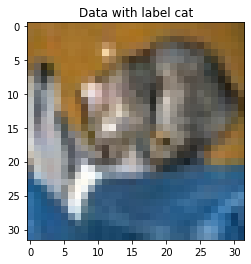

In [23]:
user.plot(true_user_data)

### Reconstruct user data:

In [24]:
reconstructed_user_data, stats = attacker.reconstruct(server_payload, shared_data, 
                                                      server.secrets, dryrun=cfg.dryrun)

# How good is the reconstruction?
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, 
                                    server_payload, server.model, user.dataloader, setup)

It: 1. Rec. loss: 0.0032. T: 0.07s
It: 1001. Rec. loss: 0.0014. T: 42.19s
It: 2001. Rec. loss: 0.0013. T: 42.08s
It: 3001. Rec. loss: 0.0013. T: 43.01s
It: 4001. Rec. loss: 0.0012. T: 41.98s
It: 5001. Rec. loss: 0.0012. T: 42.34s
It: 6001. Rec. loss: 0.0012. T: 43.17s
It: 7001. Rec. loss: 0.0012. T: 42.19s
It: 8001. Rec. loss: 0.0012. T: 41.66s
It: 9001. Rec. loss: 0.0012. T: 41.26s
It: 10001. Rec. loss: 0.0011. T: 41.27s
It: 11001. Rec. loss: 0.0011. T: 41.80s
It: 12001. Rec. loss: 0.0011. T: 41.70s
It: 13001. Rec. loss: 0.0011. T: 41.40s
It: 14001. Rec. loss: 0.0011. T: 42.42s
It: 15001. Rec. loss: 0.0011. T: 42.09s
It: 16001. Rec. loss: 0.0011. T: 41.95s
It: 17001. Rec. loss: 0.0011. T: 42.16s
It: 18001. Rec. loss: 0.0011. T: 41.75s
It: 19001. Rec. loss: 0.0011. T: 41.45s
It: 20001. Rec. loss: 0.0011. T: 41.85s
It: 21001. Rec. loss: 0.0011. T: 41.52s
It: 22001. Rec. loss: 0.0011. T: 43.05s
It: 23001. Rec. loss: 0.0011. T: 41.69s
It: 24000. Rec. loss: 0.0011. T: 41.60s
Optimal condid

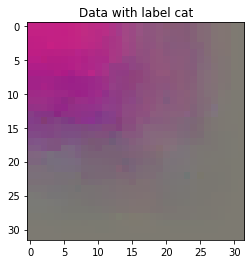

In [25]:
user.plot(reconstructed_user_data)